In [1]:
import logging
import os
from collections import OrderedDict
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

from detectron2.config import get_cfg
from detectron2.model_zoo import get_config_file, get_checkpoint_url
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.data.datasets.coco import register_coco_instances

%matplotlib inline

/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The challenge not addressed by the baseline

While we achieved what most would consider "good" performance in the baseline, there is something peculiar about the by-class performance. Some classes perform exceedingly well, but others (like the Supermarine) perform poorly in comparison. While a lot of this could be explained by poor data for a given class, which often requires either better annotations, more representative samples, or synthetic data to resolve. However, another obvious answer is the class distribution. Most real world problems are not class balanced (at least not the ones we actually care about). Datasets change and problems evolve at a rapid pace, introducing new categories to our target sets (known as an open-set problem). Given data is often scarce for new targets when they are first observed, this leads to a long-tailed class distribution (e.g. many samples for some classes, few samples for others). Without appropriate regularization techniques, classes in the tail of this distribution (few samples) often suffer in performance as the random sampling presents the head classes to the model more frequently. Lets see what the training dataset distribution looks like.

In [2]:
with open('/home/zack/datasets/manufacturer_identification/data/coco/train.json', 'r') as f:
    train_data = json.load(f)

category_id_to_name_map = {x['id']: x['name'] for x in train_data['categories']}
category_counts = {x : 0 for x in category_id_to_name_map.values()}
annotations_per_image_id = {x['id'] : 0 for x in train_data['images']}
for annotation in train_data['annotations']:
    cat_name = category_id_to_name_map[annotation['category_id']]
    category_counts[cat_name] += 1
    annotations_per_image_id[annotation['image_id']] += 1
    
category_counts = dict(sorted(category_counts.items(), key=lambda item: item[1]))
print(f'Most annotations in any given scene: {max(annotations_per_image_id.values())}')

Most annotations in any given scene: 1


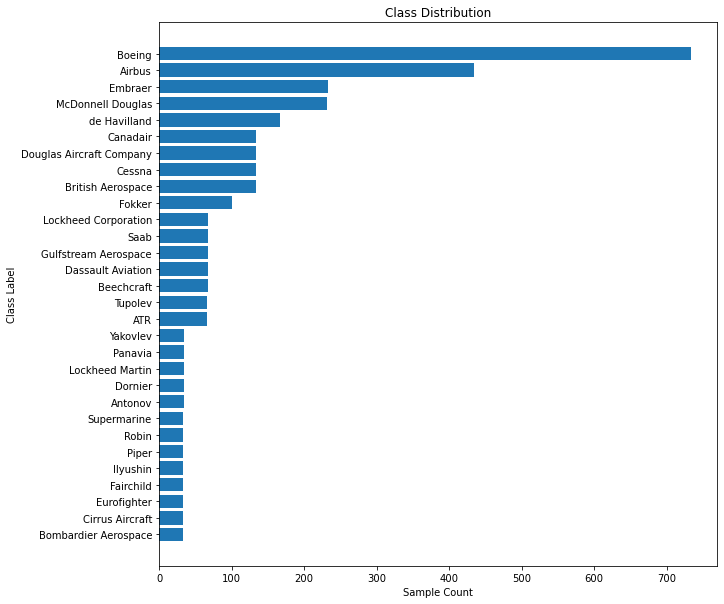

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.barh(y=list(category_counts.keys()), width=category_counts.values())
plt.title('Class Distribution')
plt.ylabel('Class Label')
plt.xlabel('Sample Count')
plt.show()

Clearly, the class distibtruion follows a long-tailed distribution which will effect our trained model. One way to overcome this is class-balanced sampling, so lets try that. To do that, we can compute the inverse class weights by inverting the sample counts, which can become our new sampling weights. Rare classes will be weighted more heavily than common classes.


## LVIS Repeat Factor Sampler

Detectron2 provides a built-in `RepeatFactorTrainingSampler` that samples images base on the frequency of items in the dataset. However, this sampler contains added complexity to account for multiple objects in a single scene- something we conveniently don't have to deal with. So, instead of using the `RepeatFactorTrainingSampler` and having to worry about the stochastic rounding, lets write our own simpler `WeightedRandomSampler`. 

First, lets walk through how we will compute the weights of the categories.

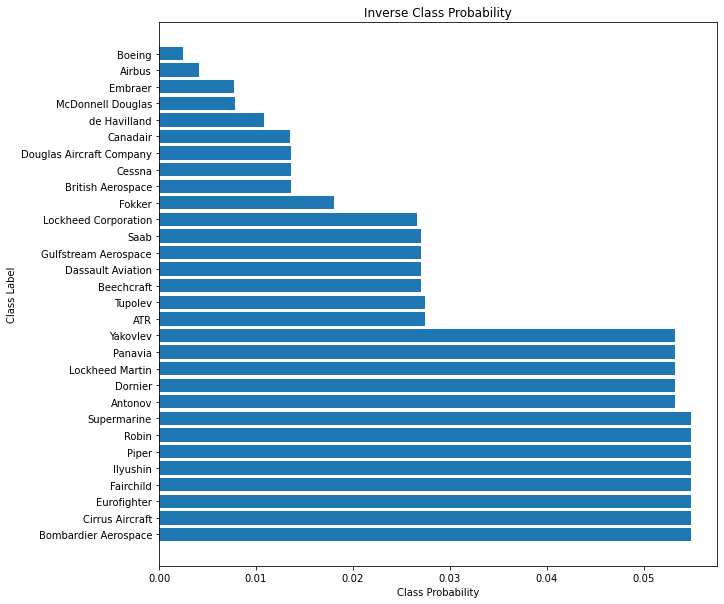

In [4]:
# Get a count for all of the categories
sample_counts = np.array(list(category_counts.values()))
# Compute the inverse frequency of all the categories (More frequent categories => Lower value)
inverse_sample_counts = 1 / sample_counts
# This is not necessary, but lets convert it into a probability distribution for visualization purposes
inverse_class_prob = inverse_sample_counts / inverse_sample_counts.sum()

fig = plt.figure(figsize=(10, 10))
plt.barh(y=list(category_counts.keys()), width=inverse_class_prob)
plt.title('Inverse Class Probability')
plt.ylabel('Class Label')
plt.xlabel('Class Probability')
plt.show()

# Custom WeightedRandomSampler

Now that we can invert the class probability distribution, lets implement it as a sampler to use during training. Let's implement a custom `WeightedRandomSampler` that computes the inverse class probabilities as shown above and scatters them to all of the samples in our training dataset. Then, each epoch, we can draw samples based on this "weighting", shuffle, then train on them.

Ultimately, we hope to overcome the class imbalance and train a better predictor on **most** categories at the potential sacrifice of performance on the head categories.

In [5]:
from detectron2.data.samplers import RepeatFactorTrainingSampler
from torch.utils.data.sampler import Sampler
from collections import defaultdict
import torch
from detectron2.utils import comm
import itertools


class WeightedRandomSampler(Sampler):
    """
    Similar to TrainingSampler, but a sample may appear more times than others based
    on its categorical probability in the dataset. Since we don't want to do too much surgery, we
    mimic the signature of RepeatFactorTrainingSampler, and will monkey patch this in.
    """

    def __init__(self, repeat_factors, *, shuffle=True, seed=None):
        """
        Args:
            repeat_factors (Tensor): a float vector, the repeat factor for each indice. When it's
                full of ones, it is equivalent to ``TrainingSampler(len(repeat_factors), ...)``.
            shuffle (bool): whether to shuffle the indices or not
            seed (int): the initial seed of the shuffle. Must be the same
                across all workers. If None, will use a random seed shared
                among workers (require synchronization among all workers).
        """
        self._shuffle = shuffle
        if seed is None:
            seed = comm.shared_random_seed()
        self._seed = int(seed)

        self._rank = comm.get_rank()
        self._world_size = comm.get_world_size()

        # Store the repeat factors for later use
        self.repeat_factors = repeat_factors


    @staticmethod
    def repeat_factors_from_category_frequency(dataset_dicts, repeat_thresh):
        """
        Compute the inverse category weights and scatter them across all samples in the dataset.

        Args:
            dataset_dicts (list[dict]): annotations in Detectron2 dataset format.
            repeat_thresh (float): This is not used

        Returns:
            torch.Tensor:
                the i-th element is the repeat factor for the dataset image at index i.
        """
        # 1. For each category c, compute the fraction of images that contain it: f(c)
        category_freq = defaultdict(int)
        for dataset_dict in dataset_dicts:  # For each image (without repeats)
            cat_ids = {ann["category_id"] for ann in dataset_dict["annotations"]}
            for cat_id in cat_ids:
                category_freq[cat_id] += 1
                
                
        inverse_category_freq = {k : 1 / v for k, v in category_freq.items()}
        total_inverse_category_freq = sum(inverse_category_freq.values())
        inverse_category_freq = {k : v / total_inverse_category_freq for k, v in inverse_category_freq.items()}
        print(f'Weighting draws by {inverse_category_freq}')
        # 3. For each image I, compute the image-level repeat factor:
        #    r(I) = max_{c in I} r(c)
        rep_factors = []
        for dataset_dict in dataset_dicts:
            cat_ids = {ann["category_id"] for ann in dataset_dict["annotations"]}
            rep_factor = max({inverse_category_freq[cat_id] for cat_id in cat_ids})
            rep_factors.append(rep_factor)

        return torch.tensor(rep_factors, dtype=torch.float32)


    def _get_epoch_indices(self, generator):
        """
        Create a list of dataset indices (with repeats) to use for one epoch.

        Args:
            generator (torch.Generator): pseudo random number generator used for
                stochastic rounding.

        Returns:
            torch.Tensor: list of dataset indices to use in one epoch. Each index
                is repeated based on its calculated repeat factor.
        """
        # Since repeat factors are fractional, we use stochastic rounding so
        # that the target repeat factor is achieved in expectation over the
        # course of training

            
        indices = torch.multinomial(self.repeat_factors, 
                                    len(self.repeat_factors), 
                                    True, 
                                    generator=None)
        return indices.long()

    def __iter__(self):
        start = self._rank
        yield from itertools.islice(self._infinite_indices(), start, None, self._world_size)

    def _infinite_indices(self):
        g = torch.Generator()
        g.manual_seed(self._seed)
        while True:
            # Sample indices with repeats determined by stochastic rounding; each
            # "epoch" may have a slightly different size due to the rounding.
            indices = self._get_epoch_indices(g)
            if self._shuffle:
                randperm = torch.randperm(len(indices), generator=g)
                yield from indices[randperm].tolist()
            else:
                yield from indices.tolist()

# Expose our Sampler to Detectron2

Implementing the sampler was the easy part, now we need to expose it to the Detectron2 API so it can instantiate it at runtime. To do this, we simply need to overwrite some methods built-in to detectron2.

In [6]:
from detectron2.data.catalog import DatasetCatalog, MetadataCatalog
from detectron2.data.common import AspectRatioGroupedDataset, DatasetFromList, MapDataset, ToIterableDataset
from detectron2.data.dataset_mapper import DatasetMapper
from detectron2.data.build import get_detection_dataset_dicts, build_batch_data_loader
from detectron2.config import configurable
from detectron2.utils.logger import _log_api_usage
import torch.utils.data as torchdata
import logging

def _train_loader_from_config(cfg, mapper=None, *, dataset=None, sampler=None):
    if dataset is None:
        dataset = get_detection_dataset_dicts(
            cfg.DATASETS.TRAIN,
            filter_empty=cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS,
            min_keypoints=cfg.MODEL.ROI_KEYPOINT_HEAD.MIN_KEYPOINTS_PER_IMAGE
            if cfg.MODEL.KEYPOINT_ON
            else 0,
            proposal_files=cfg.DATASETS.PROPOSAL_FILES_TRAIN if cfg.MODEL.LOAD_PROPOSALS else None,
        )
        _log_api_usage("dataset." + cfg.DATASETS.TRAIN[0])

    if mapper is None:
        mapper = DatasetMapper(cfg, True)

    if sampler is None:
        sampler_name = cfg.DATALOADER.SAMPLER_TRAIN
        logger = logging.getLogger(__name__)
        print("Using training sampler {}".format(sampler_name))
        logger.info("Using training sampler {}".format(sampler_name))
        if sampler_name == "TrainingSampler":
            sampler = TrainingSampler(len(dataset))
        elif sampler_name == "RepeatFactorTrainingSampler":
            repeat_factors = RepeatFactorTrainingSampler.repeat_factors_from_category_frequency(
                dataset, cfg.DATALOADER.REPEAT_THRESHOLD
            )
            sampler = RepeatFactorTrainingSampler(repeat_factors)
        elif sampler_name == "RandomSubsetTrainingSampler":
            sampler = RandomSubsetTrainingSampler(len(dataset), cfg.DATALOADER.RANDOM_SUBSET_RATIO)
        elif sampler_name == "WeightedRandomSampler":
            repeat_factors = WeightedRandomSampler.repeat_factors_from_category_frequency(
                dataset, cfg.DATALOADER.REPEAT_THRESHOLD
            )
            sampler = WeightedRandomSampler(repeat_factors)
        else:
            raise ValueError("Unknown training sampler: {}".format(sampler_name))

    return {
        "dataset": dataset,
        "sampler": sampler,
        "mapper": mapper,
        "total_batch_size": cfg.SOLVER.IMS_PER_BATCH,
        "aspect_ratio_grouping": cfg.DATALOADER.ASPECT_RATIO_GROUPING,
        "num_workers": cfg.DATALOADER.NUM_WORKERS,
    }

@configurable(from_config=_train_loader_from_config)
def build_our_custom_detection_train_loader(
    dataset,
    *,
    mapper,
    sampler=None,
    total_batch_size,
    aspect_ratio_grouping=True,
    num_workers=0,
    collate_fn=None,
):
    """
    Build a dataloader for object detection with some default features.
    Args:
        dataset (list or torch.utils.data.Dataset): a list of dataset dicts,
            or a pytorch dataset (either map-style or iterable). It can be obtained
            by using :func:`DatasetCatalog.get` or :func:`get_detection_dataset_dicts`.
        mapper (callable): a callable which takes a sample (dict) from dataset and
            returns the format to be consumed by the model.
            When using cfg, the default choice is ``DatasetMapper(cfg, is_train=True)``.
        sampler (torch.utils.data.sampler.Sampler or None): a sampler that produces
            indices to be applied on ``dataset``.
            If ``dataset`` is map-style, the default sampler is a :class:`TrainingSampler`,
            which coordinates an infinite random shuffle sequence across all workers.
            Sampler must be None if ``dataset`` is iterable.
        total_batch_size (int): total batch size across all workers.
        aspect_ratio_grouping (bool): whether to group images with similar
            aspect ratio for efficiency. When enabled, it requires each
            element in dataset be a dict with keys "width" and "height".
        num_workers (int): number of parallel data loading workers
        collate_fn: a function that determines how to do batching, same as the argument of
            `torch.utils.data.DataLoader`. Defaults to do no collation and return a list of
            data. No collation is OK for small batch size and simple data structures.
            If your batch size is large and each sample contains too many small tensors,
            it's more efficient to collate them in data loader.
    Returns:
        torch.utils.data.DataLoader:
            a dataloader. Each output from it is a ``list[mapped_element]`` of length
            ``total_batch_size / num_workers``, where ``mapped_element`` is produced
            by the ``mapper``.
    """
    if isinstance(dataset, list):
        dataset = DatasetFromList(dataset, copy=False)
    if mapper is not None:
        dataset = MapDataset(dataset, mapper)

    if isinstance(dataset, torchdata.IterableDataset):
        assert sampler is None, "sampler must be None if dataset is IterableDataset"
    else:
        if sampler is None:
            sampler = TrainingSampler(len(dataset))
        assert isinstance(sampler, torchdata.Sampler), f"Expect a Sampler but got {type(sampler)}"
    return build_batch_data_loader(
        dataset,
        sampler,
        total_batch_size,
        aspect_ratio_grouping=aspect_ratio_grouping,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

Under the hood, Detectron2 doesn't do exactly this, but a rough approximation of it.

In [7]:
from detectron2.data import build_detection_train_loader


class Trainer(DefaultTrainer):
    """
    We use the "DefaultTrainer" which contains pre-defined default logic for
    standard training workflow. They may not work for you, especially if you
    are working on a new research project. In that case you can write your
    own training loop. You can use "tools/plain_train_net.py" as an example.
    """

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return [COCOEvaluator(dataset_name, output_dir=output_folder)]
    
    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA
        # Only support some R-CNN models.
        logger.info("Running inference with test-time augmentation ...")
        model = GeneralizedRCNNWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res
    
    @classmethod
    @configurable(from_config=_train_loader_from_config)
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable
        It now calls :func:`detectron2.data.build_detection_train_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_our_custom_detection_train_loader(cfg)

# Construct the configuration

Detectron2 provides a flat-file interface, so that's what we'll be setting up in the below cells.

In [8]:
cfg = get_cfg()

# Initial model selection

A good baseline will be utilizing a Faster-RCNN with an FPN. The Faster RCNN is a two-stage object detector that has set many benchmarks over the years and still provides robust performance in the era of enhanced single-stage detectors. The FPN provides multi-scale feature maps to enhance scale invariance of the resulting detector, which is less of a concern with this dataset since all of the data is hand held imagery and the objects are fairly uniform in scale (unlike in overhead imagery). We'll use a Resnet50 as the backbone because it provides decent feature extraction performance without being computationally or memory intensive. Lets load the configuration for the R50 Faster-RCNN FPN now.

In [9]:
cfg.merge_from_file(get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'))

# Setup our data configuration

Below, we are simply defining the names of the datasets we wish to use. These datasets have not been registered yet, but we will do that in the cell after. I'm going to use 8 workers because I have a CPU with 12 cores and want to ensure I have enough processes loading data to saturate the PCIE/GPU without overtaxing my system and causing stuttering.

In [10]:
cfg.DATASETS.TRAIN = ('manu_id_train',)
cfg.DATASETS.TEST = ('manu_id_val',)
cfg.DATALOADER.NUM_WORKERS = 8

# Invoke our WeightedRandomSampler

To ensure Detectron2 uses our new sampler, we simpley define it in the config. Lets do that now.

In [11]:
cfg.DATALOADER.SAMPLER_TRAIN = 'WeightedRandomSampler'

## Register the dataset

The cell below is where the dataset is registered by name (matching the names we defined above). To do this, we simply register the directory containing the imagery and the COCO json files we created previously. Since we are training, we want to register the train and validation sets. The validation set will allow us to evaluate our model at intermediate phases throughout training and perform model selection. Since we are using the val set to select our best model, it should **not** be the same dataset we ultimately evaluate our model on (that will be the test set).

In [12]:
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_train', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/train.json')
register_coco_instances('manu_id_val', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/val.json')

# Define the model weights we wish to use for initialization

Initialization of object detectors is a massively explored sub-field of machine learning. In some cases, random initialization is okay to use, but utilizing pre-trained feature extractors (e.g. Resnet50) or full pre-trained networks (e.g. Faster-RCNN FPN) regularly provides superior performance to random initialization. There are several various pretraining regimes, of which the most populare are taking 1. Imagenet pretrained feature extractors (recognition task), 2. COCO/other detection dataset pretrained detectors (detection task), or 3. Self-supervised pretrained feature extractors (recognition task). Generally, the recognition pretrained feature extractors provide robust feature extraction capabilities and a strong starting point for optimization to take over. However, one challenge is that the remainder of the network (FPN Llteral connections, RPN, Box/Mask/Classifier heads) is still randomly initialized. Additionally, pre-training on recognition tasks often doesn't require scale information to the same level as an object detector, meaning some features may be useless/uninformative.

Using a full pretrained network is in most ways superior to a simple pretrained feature extractor. Recent work has focused on unsupervised object detection training using Selective Search or properties of DETR, but these are still early techniques. For our application and for the sake of time/complexity, I will load the weights for a R50 Faster-RCNN FPN that was pretrained on the COCO dataset with Large Scale Jitter, which is a new augmentation and learning schedule that has shown large performance benefits.

In [13]:
# Large scale jitter likely won't help us here since most objects are at the same scale, but lets load the R50-FasterRCNN-FPN LSJ model weights as a good pretrained starting point.
cfg.MODEL.WEIGHTS = get_checkpoint_url('new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py')

# Set the number of classes

The problem description says there are 41 classes, but I only see 30 classes in the labels.txt file and in the unique values of the box_labels.txt file

In [14]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 30

# Define our training schedule

Since this dataset isn't very large, we likely don't need to train for very long. I'm also pressed on time, so shorter training runs are better. 40,000 iterations seems like a reasonable place to start, but even that is likely too many iterations to train and will likely lead to overfitting. As mentioned above, one way to avoid overfitting is through utilizing a validation dataset. Detectron2 performs intermediate validation, but doesn't checkpoint based on the metric (unfortunately). After training, it will be up to us to determine the best model based on the logged metrics. Lets set the batch size to 6 (RTX 3090), and lets step the learning rate down at a schedule of 25000 and 35000 iterations. This will reduce the learning rate by some gamma (0.1) at these iterations, ideally model improving convergence as we approach a minima (hopefully the global minima and not a pesky local minima. CosineScheduler/Cyclic learning rates could help us get around that, but Detectron2 doesn't support those currently).

In [15]:
cfg.SOLVER.MAX_ITER = 40000
cfg.SOLVER.STEPS = (25000, 35000)
# I have to reduce the batch size here due to GPU memory constraints while I work on other things. This model will effectively see less data, but I think that's okay.
cfg.SOLVER.IMS_PER_BATCH = 6
# Checkpoint at a 1:1 ratio with evaluation
cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.TEST.EVAL_PERIOD = 1000

cfg.OUTPUT_DIR = './output_class_balanced'

# Train the model

Train the model, making sure to load the weights we specified above.

In [ ]:
"""
If you'd like to do anything fancier than the standard training logic,
consider writing your own training loop (see plain_train_net.py) or
subclassing the trainer.
"""
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
if cfg.TEST.AUG.ENABLED:
    trainer.register_hooks(
        [hooks.EvalHook(0, lambda: trainer.test_with_TTA(cfg, trainer.model))]
    )

trainer.train()

[04/21 23:41:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/21 23:41:28 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 23:41:28 d2.data.datasets.coco]: Loaded 3334 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/train.json
[04/21 23:41:28 d2.data.build]: Removed 0 images with no usable annotations. 3334 images left.
[04/21 23:41:28 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|      ATR      | 66           |    Airbus     | 434          |    Antonov    | 34           |
|  Beechcraft   | 67           |    Boeing     | 733          | Bombardier .. | 33           |
| British Aer.. | 133          |   Canadair    | 134          |    Cessna     | 133          |
| Cirrus Airc.. | 33           | Dassault Av.. | 67          

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (31, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (31,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (120, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (120,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.bias
backbone.fpn_lateral3.bias
backbone.fpn_lateral4.bias
backb

[04/21 23:41:29 d2.engine.train_loop]: Starting training from iteration 0


/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/zack/anaconda3/envs/riverside/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/21 23:41:37 d2.utils.events]:  eta: 4:11:28  iter: 19  total_loss: 0.2932  loss_cls: 0.1164  loss_box_reg: 0.009293  loss_rpn_cls: 0.09114  loss_rpn_loc: 0.0523  time: 0.3779  data_time: 0.0262  lr: 0.00039962  max_mem: 5885M
[04/21 23:41:46 d2.utils.events]:  eta: 4:26:19  iter: 39  total_loss: 0.2718  loss_cls: 0.1389  loss_box_reg: 0.08177  loss_rpn_cls: 0.01241  loss_rpn_loc: 0.01527  time: 0.4034  data_time: 0.0060  lr: 0.00079922  max_mem: 5885M
[04/21 23:41:54 d2.utils.events]:  eta: 4:37:39  iter: 59  total_loss: 0.2232  loss_cls: 0.1148  loss_box_reg: 0.08254  loss_rpn_cls: 0.008943  loss_rpn_loc: 0.01049  time: 0.4116  data_time: 0.0060  lr: 0.0011988  max_mem: 6157M
[04/21 23:42:03 d2.utils.events]:  eta: 4:38:07  iter: 79  total_loss: 0.2075  loss_cls: 0.1072  loss_box_reg: 0.08508  loss_rpn_cls: 0.005604  loss_rpn_loc: 0.009233  time: 0.4144  data_time: 0.0061  lr: 0.0015984  max_mem: 6157M
[04/21 23:42:11 d2.utils.events]:  eta: 4:38:22  iter: 99  total_loss: 0.2186  

[04/21 23:46:41 d2.utils.events]:  eta: 4:40:51  iter: 719  total_loss: 0.1987  loss_cls: 0.1396  loss_box_reg: 0.04933  loss_rpn_cls: 0.002101  loss_rpn_loc: 0.007917  time: 0.4321  data_time: 0.0062  lr: 0.014386  max_mem: 6293M
[04/21 23:46:49 d2.utils.events]:  eta: 4:40:25  iter: 739  total_loss: 0.1833  loss_cls: 0.1276  loss_box_reg: 0.04308  loss_rpn_cls: 0.001112  loss_rpn_loc: 0.006278  time: 0.4312  data_time: 0.0060  lr: 0.014785  max_mem: 6293M
[04/21 23:46:57 d2.utils.events]:  eta: 4:39:50  iter: 759  total_loss: 0.1684  loss_cls: 0.1171  loss_box_reg: 0.04106  loss_rpn_cls: 0.001439  loss_rpn_loc: 0.006578  time: 0.4303  data_time: 0.0061  lr: 0.015185  max_mem: 6293M
[04/21 23:47:05 d2.utils.events]:  eta: 4:39:41  iter: 779  total_loss: 0.1766  loss_cls: 0.1214  loss_box_reg: 0.04123  loss_rpn_cls: 0.001043  loss_rpn_loc: 0.007177  time: 0.4300  data_time: 0.0061  lr: 0.015584  max_mem: 6293M
[04/21 23:47:14 d2.utils.events]:  eta: 4:39:04  iter: 799  total_loss: 0.18

[04/21 23:49:57 d2.evaluation.evaluator]: Inference done 2206/3333. Dataloading: 0.0008 s/iter. Inference: 0.0333 s/iter. Eval: 0.0001 s/iter. Total: 0.0343 s/iter. ETA=0:00:38
[04/21 23:50:02 d2.evaluation.evaluator]: Inference done 2358/3333. Dataloading: 0.0008 s/iter. Inference: 0.0333 s/iter. Eval: 0.0001 s/iter. Total: 0.0342 s/iter. ETA=0:00:33
[04/21 23:50:07 d2.evaluation.evaluator]: Inference done 2503/3333. Dataloading: 0.0008 s/iter. Inference: 0.0332 s/iter. Eval: 0.0001 s/iter. Total: 0.0342 s/iter. ETA=0:00:28
[04/21 23:50:12 d2.evaluation.evaluator]: Inference done 2640/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s/iter. Eval: 0.0001 s/iter. Total: 0.0344 s/iter. ETA=0:00:23
[04/21 23:50:17 d2.evaluation.evaluator]: Inference done 2786/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s/iter. Eval: 0.0001 s/iter. Total: 0.0344 s/iter. ETA=0:00:18
[04/21 23:50:22 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0008 s/iter. Inference: 0.0334 s

[04/21 23:52:24 d2.utils.events]:  eta: 4:37:38  iter: 1239  total_loss: 0.1191  loss_cls: 0.08362  loss_box_reg: 0.02577  loss_rpn_cls: 0.0008107  loss_rpn_loc: 0.006172  time: 0.4319  data_time: 0.0069  lr: 0.02  max_mem: 6293M
[04/21 23:52:33 d2.utils.events]:  eta: 4:37:31  iter: 1259  total_loss: 0.1302  loss_cls: 0.08886  loss_box_reg: 0.03367  loss_rpn_cls: 0.001026  loss_rpn_loc: 0.007664  time: 0.4319  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/21 23:52:42 d2.utils.events]:  eta: 4:37:19  iter: 1279  total_loss: 0.1532  loss_cls: 0.1048  loss_box_reg: 0.0399  loss_rpn_cls: 0.001559  loss_rpn_loc: 0.006812  time: 0.4322  data_time: 0.0070  lr: 0.02  max_mem: 6293M
[04/21 23:52:51 d2.utils.events]:  eta: 4:37:12  iter: 1299  total_loss: 0.1325  loss_cls: 0.09292  loss_box_reg: 0.03188  loss_rpn_cls: 0.0008813  loss_rpn_loc: 0.006295  time: 0.4324  data_time: 0.0073  lr: 0.02  max_mem: 6293M
[04/21 23:53:00 d2.utils.events]:  eta: 4:37:03  iter: 1319  total_loss: 0.1311  los

[04/21 23:57:34 d2.utils.events]:  eta: 4:38:04  iter: 1939  total_loss: 0.08775  loss_cls: 0.05513  loss_box_reg: 0.02703  loss_rpn_cls: 0.0005604  loss_rpn_loc: 0.005444  time: 0.4346  data_time: 0.0065  lr: 0.02  max_mem: 6293M
[04/21 23:57:42 d2.utils.events]:  eta: 4:38:06  iter: 1959  total_loss: 0.1017  loss_cls: 0.06009  loss_box_reg: 0.03061  loss_rpn_cls: 0.0004905  loss_rpn_loc: 0.006911  time: 0.4346  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/21 23:57:52 d2.utils.events]:  eta: 4:37:49  iter: 1979  total_loss: 0.09166  loss_cls: 0.05517  loss_box_reg: 0.02744  loss_rpn_cls: 0.001497  loss_rpn_loc: 0.008883  time: 0.4346  data_time: 0.0074  lr: 0.02  max_mem: 6293M
WARNING [04/21 23:58:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/21 23:58:02 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/21 23:58:02 d2.data.d

[04/21 23:59:58 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/21 23:59:58 d2.evaluation.testing]: copypaste: Task: bbox
[04/21 23:59:58 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/21 23:59:58 d2.evaluation.testing]: copypaste: 44.5509,56.7519,54.5036,nan,0.0000,44.5553
[04/21 23:59:58 d2.utils.events]:  eta: 4:37:31  iter: 1999  total_loss: 0.0934  loss_cls: 0.05469  loss_box_reg: 0.0301  loss_rpn_cls: 0.0007762  loss_rpn_loc: 0.006234  time: 0.4346  data_time: 0.0073  lr: 0.02  max_mem: 6293M
[04/22 00:00:06 d2.utils.events]:  eta: 4:37:11  iter: 2019  total_loss: 0.09154  loss_cls: 0.05538  loss_box_reg: 0.02866  loss_rpn_cls: 0.0005805  loss_rpn_loc: 0.006182  time: 0.4344  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 00:00:15 d2.utils.events]:  eta: 4:36:54  iter: 2039  total_loss: 0.08754  loss_cls: 0.05652  loss_box_reg: 0.02482  loss_rpn_cls: 0.0005258  loss_rpn_loc: 0.005976  time: 0.4343  data_time: 0.0074  lr: 0.02  max_m

[04/22 00:04:46 d2.utils.events]:  eta: 4:29:58  iter: 2659  total_loss: 0.0726  loss_cls: 0.03936  loss_box_reg: 0.03152  loss_rpn_cls: 0.0005355  loss_rpn_loc: 0.006098  time: 0.4344  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:04:55 d2.utils.events]:  eta: 4:30:11  iter: 2679  total_loss: 0.07492  loss_cls: 0.04262  loss_box_reg: 0.02656  loss_rpn_cls: 0.0001917  loss_rpn_loc: 0.00603  time: 0.4346  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:05:04 d2.utils.events]:  eta: 4:29:38  iter: 2699  total_loss: 0.07113  loss_cls: 0.03649  loss_box_reg: 0.02711  loss_rpn_cls: 0.0002083  loss_rpn_loc: 0.00516  time: 0.4347  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:05:12 d2.utils.events]:  eta: 4:29:13  iter: 2719  total_loss: 0.07523  loss_cls: 0.03771  loss_box_reg: 0.02796  loss_rpn_cls: 0.0005268  loss_rpn_loc: 0.006775  time: 0.4346  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:05:21 d2.utils.events]:  eta: 4:28:48  iter: 2739  total_loss: 0.0708

[04/22 00:08:49 d2.evaluation.evaluator]: Inference done 2934/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:13
[04/22 00:08:54 d2.evaluation.evaluator]: Inference done 3084/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0327 s/iter. ETA=0:00:08
[04/22 00:08:59 d2.evaluation.evaluator]: Inference done 3239/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:03
[04/22 00:09:02 d2.evaluation.evaluator]: Total inference time: 0:01:48.998620 (0.032752 s / iter per device, on 1 devices)
[04/22 00:09:02 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:45 (0.031797 s / iter per device, on 1 devices)
[04/22 00:09:02 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 00:09:02 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 00:11:13 d2.utils.events]:  eta: 4:22:04  iter: 3299  total_loss: 0.08774  loss_cls: 0.04264  loss_box_reg: 0.03673  loss_rpn_cls: 0.0003483  loss_rpn_loc: 0.005478  time: 0.4335  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:11:21 d2.utils.events]:  eta: 4:21:51  iter: 3319  total_loss: 0.08143  loss_cls: 0.03986  loss_box_reg: 0.03386  loss_rpn_cls: 0.0004121  loss_rpn_loc: 0.006002  time: 0.4334  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:11:30 d2.utils.events]:  eta: 4:21:34  iter: 3339  total_loss: 0.07378  loss_cls: 0.03576  loss_box_reg: 0.02949  loss_rpn_cls: 0.000354  loss_rpn_loc: 0.005849  time: 0.4334  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:11:39 d2.utils.events]:  eta: 4:21:16  iter: 3359  total_loss: 0.07246  loss_cls: 0.03501  loss_box_reg: 0.02983  loss_rpn_cls: 0.0002384  loss_rpn_loc: 0.006743  time: 0.4334  data_time: 0.0060  lr: 0.02  max_mem: 6293M
[04/22 00:11:47 d2.utils.events]:  eta: 4:21:00  iter: 3379  total_loss: 0.06

WARNING [04/22 00:16:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 00:16:10 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 00:16:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 00:16:10 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 00:16:10 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 00:16:10 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 00:16:11 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0008 s/iter. Inference: 0.0322 s/iter. Eval: 0.0001 s/iter. Total: 0.0331 s/iter. ETA=0:01:50
[04/22 00:16:16 d2.evaluation.evaluator]: Inference done 157/3333. Dataloading: 0.0007 s/iter. Inference: 0.0333 s/

[04/22 00:18:05 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 00:18:05 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 00:18:05 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 00:18:05 d2.evaluation.testing]: copypaste: 70.0798,86.7400,84.3338,nan,0.0000,70.0847
[04/22 00:18:05 d2.utils.events]:  eta: 4:13:07  iter: 3999  total_loss: 0.04782  loss_cls: 0.02239  loss_box_reg: 0.02287  loss_rpn_cls: 0.000186  loss_rpn_loc: 0.004336  time: 0.4317  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:18:14 d2.utils.events]:  eta: 4:12:57  iter: 4019  total_loss: 0.05185  loss_cls: 0.02238  loss_box_reg: 0.02243  loss_rpn_cls: 0.0001685  loss_rpn_loc: 0.004839  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:18:23 d2.utils.events]:  eta: 4:12:53  iter: 4039  total_loss: 0.04769  loss_cls: 0.02076  loss_box_reg: 0.02266  loss_rpn_cls: 0.000422  loss_rpn_loc: 0.004965  time: 0.4317  data_time: 0.0062  lr: 0.02  max_m

[04/22 00:22:54 d2.utils.events]:  eta: 4:13:10  iter: 4659  total_loss: 0.04494  loss_cls: 0.01772  loss_box_reg: 0.02392  loss_rpn_cls: 0.0003118  loss_rpn_loc: 0.005681  time: 0.4324  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:23:02 d2.utils.events]:  eta: 4:13:11  iter: 4679  total_loss: 0.04218  loss_cls: 0.01716  loss_box_reg: 0.02075  loss_rpn_cls: 0.0002039  loss_rpn_loc: 0.004771  time: 0.4323  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:23:11 d2.utils.events]:  eta: 4:12:56  iter: 4699  total_loss: 0.04221  loss_cls: 0.01522  loss_box_reg: 0.02158  loss_rpn_cls: 0.0001643  loss_rpn_loc: 0.00499  time: 0.4323  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:23:20 d2.utils.events]:  eta: 4:12:39  iter: 4719  total_loss: 0.04722  loss_cls: 0.0191  loss_box_reg: 0.02197  loss_rpn_cls: 0.0001854  loss_rpn_loc: 0.005183  time: 0.4323  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:23:28 d2.utils.events]:  eta: 4:12:31  iter: 4739  total_loss: 0.043

[04/22 00:26:58 d2.evaluation.evaluator]: Inference done 2936/3333. Dataloading: 0.0008 s/iter. Inference: 0.0316 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:12
[04/22 00:27:03 d2.evaluation.evaluator]: Inference done 3086/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:08
[04/22 00:27:08 d2.evaluation.evaluator]: Inference done 3236/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/iter. Eval: 0.0001 s/iter. Total: 0.0326 s/iter. ETA=0:00:03
[04/22 00:27:11 d2.evaluation.evaluator]: Total inference time: 0:01:48.772802 (0.032684 s / iter per device, on 1 devices)
[04/22 00:27:11 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:45 (0.031703 s / iter per device, on 1 devices)
[04/22 00:27:11 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/22 00:27:11 d2.evaluation.coco_evaluation]: Saving results to ./output_class_balanced/inference/coco_instances_results.json
[

[04/22 00:29:20 d2.utils.events]:  eta: 4:11:18  iter: 5299  total_loss: 0.03893  loss_cls: 0.01253  loss_box_reg: 0.01898  loss_rpn_cls: 0.0003951  loss_rpn_loc: 0.005084  time: 0.4320  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:29:29 d2.utils.events]:  eta: 4:11:04  iter: 5319  total_loss: 0.03931  loss_cls: 0.01356  loss_box_reg: 0.01809  loss_rpn_cls: 0.0001628  loss_rpn_loc: 0.005102  time: 0.4320  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:29:38 d2.utils.events]:  eta: 4:10:41  iter: 5339  total_loss: 0.04333  loss_cls: 0.01644  loss_box_reg: 0.02088  loss_rpn_cls: 0.0003589  loss_rpn_loc: 0.00508  time: 0.4320  data_time: 0.0062  lr: 0.02  max_mem: 6293M
[04/22 00:29:46 d2.utils.events]:  eta: 4:10:16  iter: 5359  total_loss: 0.04323  loss_cls: 0.01471  loss_box_reg: 0.01962  loss_rpn_cls: 0.0002353  loss_rpn_loc: 0.004888  time: 0.4320  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:29:55 d2.utils.events]:  eta: 4:10:06  iter: 5379  total_loss: 0.03

WARNING [04/22 00:34:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/22 00:34:26 d2.data.datasets.coco]: Loaded 3333 images in COCO format from /home/zack/datasets/manufacturer_identification/data/coco/val.json
[04/22 00:34:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/22 00:34:26 d2.data.common]: Serializing 3333 elements to byte tensors and concatenating them all ...
[04/22 00:34:26 d2.data.common]: Serialized dataset takes 0.85 MiB
[04/22 00:34:26 d2.evaluation.evaluator]: Start inference on 3333 batches
[04/22 00:34:27 d2.evaluation.evaluator]: Inference done 11/3333. Dataloading: 0.0006 s/iter. Inference: 0.0303 s/iter. Eval: 0.0001 s/iter. Total: 0.0311 s/iter. ETA=0:01:43
[04/22 00:34:32 d2.evaluation.evaluator]: Inference done 164/3333. Dataloading: 0.0008 s/iter. Inference: 0.0317 s/

[04/22 00:36:21 d2.engine.defaults]: Evaluation results for manu_id_val in csv format:
[04/22 00:36:21 d2.evaluation.testing]: copypaste: Task: bbox
[04/22 00:36:21 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[04/22 00:36:21 d2.evaluation.testing]: copypaste: 74.2909,89.8920,87.6466,nan,0.0000,74.3002
[04/22 00:36:21 d2.utils.events]:  eta: 4:05:06  iter: 5999  total_loss: 0.03806  loss_cls: 0.01483  loss_box_reg: 0.01774  loss_rpn_cls: 0.0001935  loss_rpn_loc: 0.004904  time: 0.4324  data_time: 0.0061  lr: 0.02  max_mem: 6293M
[04/22 00:36:30 d2.utils.events]:  eta: 4:05:04  iter: 6019  total_loss: 0.03803  loss_cls: 0.01206  loss_box_reg: 0.0179  loss_rpn_cls: 0.0002233  loss_rpn_loc: 0.00436  time: 0.4325  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:36:40 d2.utils.events]:  eta: 4:04:58  iter: 6039  total_loss: 0.03877  loss_cls: 0.01209  loss_box_reg: 0.01867  loss_rpn_cls: 0.0001689  loss_rpn_loc: 0.004394  time: 0.4327  data_time: 0.0066  lr: 0.02  max_m

[04/22 00:41:03 d2.utils.events]:  eta: 3:54:23  iter: 6659  total_loss: 0.03622  loss_cls: 0.01208  loss_box_reg: 0.01769  loss_rpn_cls: 0.00023  loss_rpn_loc: 0.005556  time: 0.4318  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:41:11 d2.utils.events]:  eta: 3:54:10  iter: 6679  total_loss: 0.03272  loss_cls: 0.01128  loss_box_reg: 0.01609  loss_rpn_cls: 0.0001373  loss_rpn_loc: 0.005361  time: 0.4317  data_time: 0.0064  lr: 0.02  max_mem: 6293M
[04/22 00:41:19 d2.utils.events]:  eta: 3:53:57  iter: 6699  total_loss: 0.0355  loss_cls: 0.01132  loss_box_reg: 0.01646  loss_rpn_cls: 0.0003391  loss_rpn_loc: 0.006676  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:41:28 d2.utils.events]:  eta: 3:53:29  iter: 6719  total_loss: 0.03334  loss_cls: 0.01007  loss_box_reg: 0.01657  loss_rpn_cls: 0.0002427  loss_rpn_loc: 0.004166  time: 0.4317  data_time: 0.0063  lr: 0.02  max_mem: 6293M
[04/22 00:41:37 d2.utils.events]:  eta: 3:53:41  iter: 6739  total_loss: 0.0405

# Training Discussion and Testing

The model appears to have converged which is a good sign, and AP looks reasonable at 90.716 at final validation. AP is Average Precision (out of all the calls we made, how many were actually our target) and is evaluated over a sweeping range of Intersection-over-Union thresholds from 0.5 -> 0.95 at 0.05 increments. This gives us a pretty good idea that our boxes and classifications are fairly accurate.  For real-world imagery (specifically overhead imagery), we are often more concerned with AP50 (Average Precision at IoU=0.5) since it's difficult to get humans to produce perfect annotations, and we reach an astounding 96.178 AP50 here. However, AP50 reaching this high metric is no surprise considering how easy this data really is.

Now for the fun part- testing of our model. Lets load up the test set and evaluate model performance at the last iteration of training.

In [ ]:
cfg.DATASETS.TEST = ('manu_id_test',)
image_root = '/home/zack/datasets/manufacturer_identification/data/images'
register_coco_instances('manu_id_test', {}, image_root=image_root, json_file='/home/zack/datasets/manufacturer_identification/data/coco/test.json')

In [ ]:
trainer.test(cfg=cfg, model=trainer.model)

# Testing Discussion - Class Balanced

The results are better than the validation dataset- Excellent! However, I believe we can do better. Taking the model at the last iteration is likely using an overfitted model. Let's load the best model (according to the validation dataset) and evaluate its performance. Assuming there is no covariate shift between the val/test sets, we should se better performance.

In [ ]:
with open('output_class_balanced/metrics.json', 'r') as f:
    metrics = [eval(x.replace('\n', '').replace('NaN', '0')) for x in f.readlines()]
metrics = {x['iteration'] : x for i, x in enumerate(metrics) if 'bbox/AP' in x}
bbox_ap = {k : v['bbox/AP'] for k, v in metrics.items()}
best_ap_iter = max(bbox_ap, key= lambda x: bbox_ap[x])
print(f'Best bbox/AP was achieved at iteration {best_ap_iter} with a value of {bbox_ap[best_ap_iter]}')
print(f"")

In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer

model = build_model(cfg)
DetectionCheckpointer(model).load(f'output_class_balanced/model_{best_ap_iter:07}.pth')

trainer.test(cfg=cfg, model=model)

# Visualize the results

Lets load up a simple test image and verify our model can predict correctly.

In [ ]:
from detectron2.data import transforms as T
from detectron2.utils.visualizer import Visualizer

class DefaultPredictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg, model):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = model
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [ ]:
with open('/home/zack/datasets/manufacturer_identification/data/coco/test.json', 'r') as f:
    test_data = json.load(f)
    random_idx = np.random.choice(len(test_data['images']), 1)[0]
    test_image = test_data['images'][random_idx]
    test_image_file = os.path.join('/home/zack/datasets/manufacturer_identification/data/images', test_image['file_name'])

In [ ]:
im = cv2.imread(test_image_file)
print(im.shape)
plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])   

predictor = DefaultPredictor(cfg, model)

outputs = predictor(im[..., ::-1])
        
        
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])